# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation
We then can train our network using the iref PPI and these different data sources.

In [1]:
import h5py
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn
plt.rc('font', family='Times New Roman')
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the Data from three containers

In [2]:
# mutation frequencies
with h5py.File('../../data/pancancer/mutfreq_iref_unbalanced_syn.h5', 'r') as f:
    network = f['network'][:]
    mutfreq_features = f['features_mean'][:]
    #features_mean = f['features_mean'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

# methylation levels
with h5py.File('../../data/pancancer/iref_methylation_450k_1000bpprom.h5', 'r') as f:
    meth_features = f['features'][:]

# gene expression
with h5py.File('../../data/pancancer/iref_tcga_expression_filter100.h5', 'r') as f:
    ge_features = f['features'][:]

## Join Multi-Omics to form one feature matrix

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
ge_norm = min_max_scaler.fit_transform(ge_features.T).T
mutfreq_norm = min_max_scaler.fit_transform(mutfreq_features.T).T
meth_norm = min_max_scaler.fit_transform(meth_features.T).T

multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)

### Plot Distribution of Features

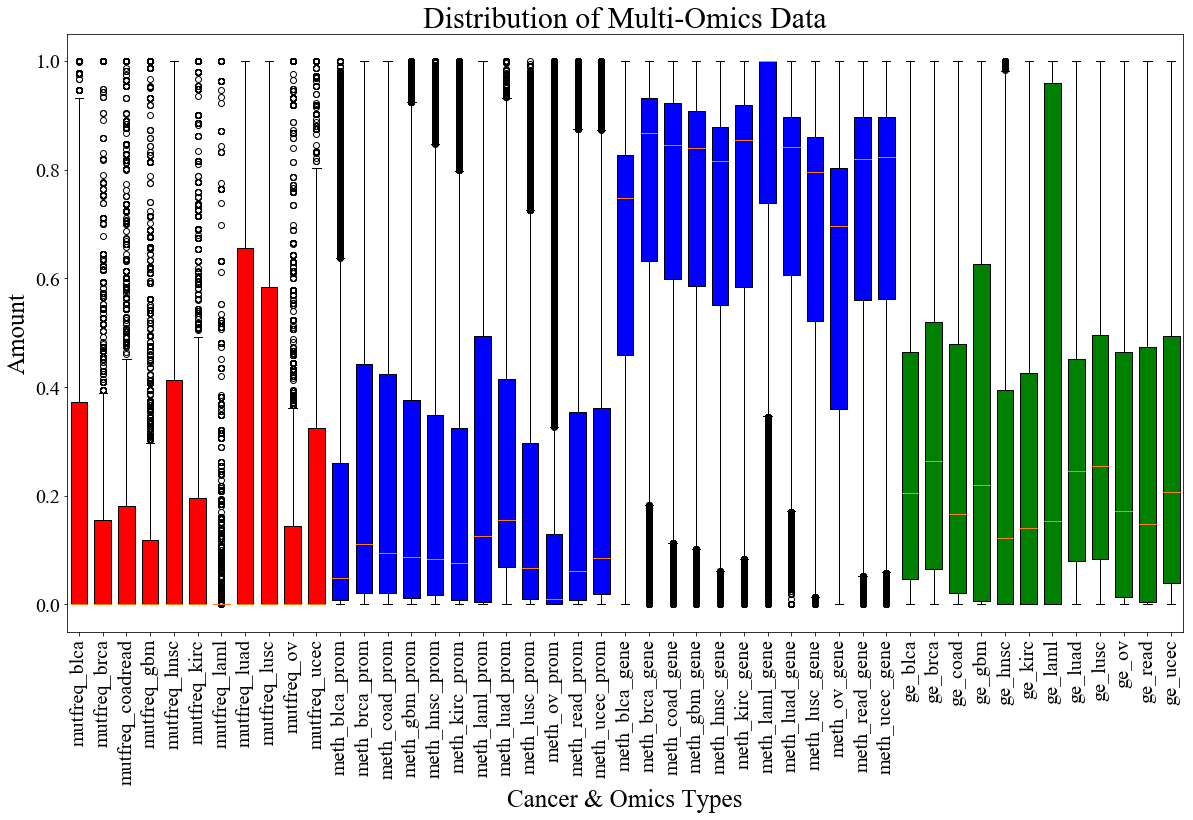

In [4]:
# plot distribution of features

fig = plt.figure(figsize=(20, 11))

# mutation frequencies
cancer_names = ['blca', 'brca', 'coadread', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'ucec']
feat_names_mut = ['mutfreq_'+i for i in cancer_names]

# gene expression
cnames_full = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec']
feat_names_ge = ['ge_'+i for i in cnames_full]

# methylation
feat_names_meth = ['meth_{}_prom'.format(i) for i in cnames_full] + ['meth_{}_gene'.format(i) for i in cnames_full]
feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

# plot
x = plt.boxplot(multi_omics_features, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, multi_omics_features.shape[1]+1), feat_names_all, rotation='vertical', fontsize=20)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*11 + ['blue']*24 + ['green']*12
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-0.05, 1.5])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.title('Distribution of Multi-Omics Data', fontsize=30)
fig.savefig('multi_omics_feature_distribution_normed.png', dpi=300)

## Write back everything to container

In [13]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_test, train_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [14]:
multi_omics_features = np.concatenate((mutfreq_features, meth_features, ge_features), axis=1)
write_hdf5_container('../../data/pancancer/iref_multiomics_norm_tcgage_meth1000bpprom.h5', network,
                     multi_omics_features, node_names, y_train, y_test, train_mask, test_mask,
                     feat_names_all)

Container written to ../../data/pancancer/iref_multiomics_norm_tcgage_meth1000bpprom.h5


In [16]:
multi_omics_features_nogbmeth = np.concatenate((mutfreq_features, meth_features[:, :12], ge_features), axis=1)
write_hdf5_container('../../data/pancancer/iref_multiomics_norm_tcgage_methpromonly1000bp.h5', network,
                     multi_omics_features_nogbmeth, node_names, y_train, y_test, train_mask, test_mask,
                     feat_names_mut + feat_names_meth[:12] + feat_names_ge)

Container written to ../../data/pancancer/iref_multiomics_norm_tcgage_methpromonly1000bp.h5


## Compute Containers for combinations of two omics data

In [17]:
meth_ge_features = np.concatenate((meth_features, ge_features), axis=1)
write_hdf5_container('../../data/pancancer/iref_meth1000bpprom_and_tcgage_norm.h5', network,
                     meth_ge_features, node_names, y_train, y_test, train_mask, test_mask,
                     feat_names_meth + feat_names_ge)

Container written to ../../data/pancancer/iref_meth1000bpprom_and_tcgage_norm.h5


In [18]:
meth_mutfreq_features = np.concatenate((meth_features, mutfreq_features), axis=1)
write_hdf5_container('../../data/pancancer/iref_meth1000bpprom_and_mutfreq_norm.h5', network,
                     meth_mutfreq_features, node_names, y_train, y_test, train_mask, test_mask,
                     feat_names_meth + feat_names_mut)

Container written to ../../data/pancancer/iref_meth1000bpprom_and_mutfreq_norm.h5


In [19]:
mutfreq_ge_features = np.concatenate((mutfreq_features, ge_features), axis=1)
write_hdf5_container('../../data/pancancer/iref_mutfreq_and_tcgagege_norm.h5', network,
                     mutfreq_ge_features, node_names, y_train, y_test, train_mask, test_mask,
                     feat_names_mut + feat_names_ge)

Container written to ../../data/pancancer/iref_mutfreq_and_tcgagege_norm.h5
